# **3.1 ED :: Operators based on first derivative**

## **Intro**

Edge detection is an image processing technique for finding those points in images that represent brightness variations or *edges*. It has many applications for image segmentation and data extraction.

As commented, edges can be defined as transitions between image regions that have different gray levels (intensities). In this way, the unidimensional, continuous model of an ideal edge is:

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/model_of_ideal_edge.PNG" width="600">
</center>

However, in real images that model is not exactly followed by edges since images are discrete, and they are corrupted by noise.

### **Error types related to edge detection**

Finding edges properly is not a straightforward task, as there exist different errors that can appear when applying edge detection techniques: **Detection errors, Localization errors and Multiple response.**

When designing a good edge detector, the goal is to achieve low detection and localization errors, as well as to avoid multiple responses.

## **Problem context - Edge detection for medical images**

Edge detection in medical images is of capital importance for diagnosis of different diseases (e.g., the detection of tumor cells) in human organs such as lungs and prostates, becoming an essential pre-processing step in medical image segmentation.

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/hospital_clinico.jpg" width="400">
</center>

In this context, *Hospital Clínico*, a very busy hospital in Málaga is asking local engineering students to join their research team. They are looking for a person with knowledge in image processing and, in order to ensure it, they have published 3 medical images: `medical_1.jpg`, `medical_2.jpg` and `medical_3.jpg`. They have asked us to perform accurate edge detection in the three images, as well as to provide an explanation of how it has been made.

## **Operators based on first derivative (gradient)**

In this notebook we will cover **first-derivative** based operators, which try to detect borders by looking at abrupt intensity differences in neighbor pixels. The first derivative will be **maximum** where there is a more abrupt change in pixel intesitiy.

Concretely, the techniques based on the first derivative explored here are:

- Discrete approximations of a **gradient operator** (Sobel, Prewitt, Roberts, etc., Section 3.1.1).
- The **Derivative of Gaussian** (DroG) operator (Section 3.1.2).

**This notebook contains <font color=green>5 assignments</font> and <font color=blue>2 discussions</font>**

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = '/gdrive/My Drive/Colab Notebooks/Chapter 3. Edge detection/images/'

To face this challenge, we are going to use plenty edge detection methods, which will be tested and compared in order to determine the best option.

### <font color="green"><b>ASSIGNMENT #1: Display the images</b></font>
First, **display the provided images** in a $1\times3$ figure to get an idea about what we are dealing with.

*Note: As most medical images do not provide color information, we are going to use border detection in greyscale images.*

> <font color="orange">Tip: Different approaches can be followed for edge detection in color images, like converting to YCrCb color space (appendix 2), or detecting edges on each RGB channel.</font>

Text(0.5, 1.0, 'medical_3')

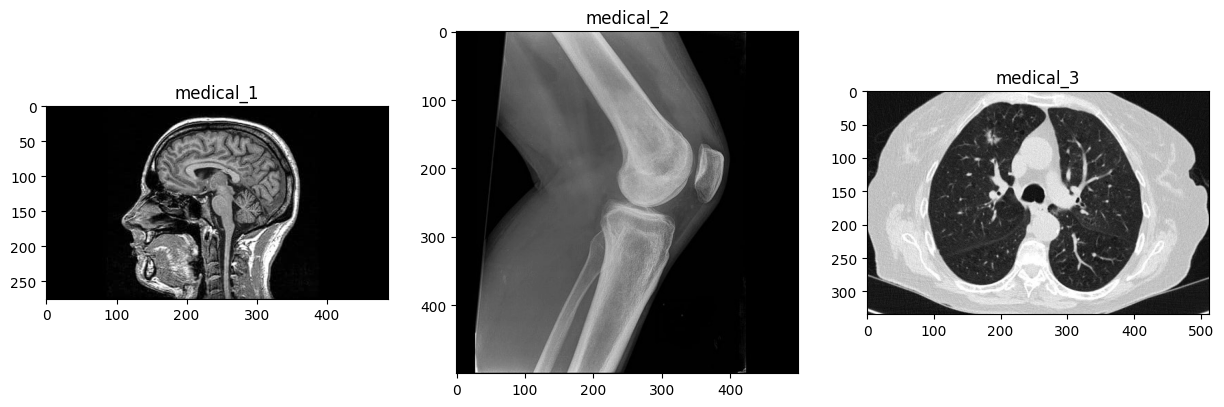

In [20]:
# ASSIGNMENT #1
# Display the provided images in a 1x3 plot to see what are we dealing with
# Write your code here!
medical_1 = cv2.imread(images_path + 'medical_1.jpg',0) # 0 read any image as gray
medical_2 = cv2.imread(images_path + 'medical_2.jpg',0) # 0 read any image as gray
medical_3 = cv2.imread(images_path + 'medical_3.jpg',0) # 0 read any image as gray
plt.subplot(1,3,1)
plt.imshow(medical_1, cmap='gray')
plt.title('medical_1')
plt.subplot(1,3,2)
plt.imshow(medical_2, cmap='gray')
plt.title('medical_2')
plt.subplot(1,3,3)
plt.imshow(medical_3, cmap='gray')
plt.title('medical_3')

## **3.1.1 Discrete approximations of a gradient operator**

The first bunch of methods that we are going to explore carry out a **discrete approximation of a gradient operator** based on the differences between gray (intensity) levels.

These approximations are typically implemented through the convolution of the image $\mathbf{F}$ with a pair of kernels $\mathbf{H_C}$ (for columns, detecting vertical edges) and $\mathbf{H_R}$ (for rows, detecting horizontal ones), that is:

$$
\nabla  \mathbf{F}(x,y) =
\begin{bmatrix}
	\mathbf{G_C} \\ \mathbf{G_R}
\end{bmatrix} =
\begin{bmatrix}
	 \mathbf{F} \otimes \mathbf{H_C} \\  \mathbf{F} \otimes \mathbf{H_R}
\end{bmatrix}
$$

Perhaps the most popular operator doing this is **Sobel**, although there are many of them that provide acceptable results. These operators use the aforementioned two kernels (typically of size $3\times3$ or $5\times5$) which are convolved with the original image to calculate approximations of the derivative images $\mathbf{G_C}, \mathbf{G_R}$ in the horizontal and vertical directions. In general, the $3\times3$ kernels are like this:$\\[5pt]$

<table style="background-color: red; display: table-cell; border: 1px solid black;">
	<tr>
		<td><b>Name</b></td>
		<td align=center><b>$\mathbf{H_R}$</b></td>
		<td align=center><b>$\mathbf{H_C}$</b></td>
	</tr>
	<tr>
		<td>In general</td>
		<td align=center>
			$$\frac{1}{2+K}\begin{bmatrix}
				1 & 0 & -1 \\
				K & \color{blue}{0} & -K \\
				1 & 0 & -1
			\end{bmatrix}
			$$    
		</td>
		<td align=center>
			$$\frac{1}{2+K}\begin{bmatrix}
				-1 & -K & -1 \\
				0 & \color{blue}{0} & 0 \\
				1 & K & 1
			\end{bmatrix}
			$$
		</td>
	</tr>
</table>

For the Sobel operator, $K = 2$. You can find more versions of this detector in the course slides.

At this point we know how to perform a discrete approximation of a gradient operator through the application of a convolution operation with two different kernels, that is:

$$\nabla  F(x,y) =
\begin{bmatrix}
F \otimes H_C \\ F \otimes H_R
\end{bmatrix}$$

But, how could we use the output of those computations to detect edges? The following figure clarifies that!

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch3_gradient_scheme.png" width="900">
</center>

**Kernel sizes**

The size of the kernel directly affects the quality of the detection and the localization:
- Small template:
  - more precise localization (good localization).
  - more affected by noise (likely produces false positives).
- Large template:
  - less precise localization.
  - more robust to noise (good detector).
  - higher computational cost ($O(N \times N)$)

### **<font color=green>ASSIGNMENT #2: Sobel derivatives</font>**
Now that we have acquired a basic understanding of these methods, use the Sobel kernels to compute both derivatives (horizontal and vertical) and display them along with the original image (`medical_3.jpg`) in a $1\times3$ figure.

> <font color=orange>Notice that the derivative image values can be **positive and negative**, caused by the negative values in the kernel. This implies that the desired depth of the destination image (`ddepth`) has to be at least a signed data type when calling to the `filter2D()` method.</font>

Text(0.5, 1.0, 'Vertical derivative')

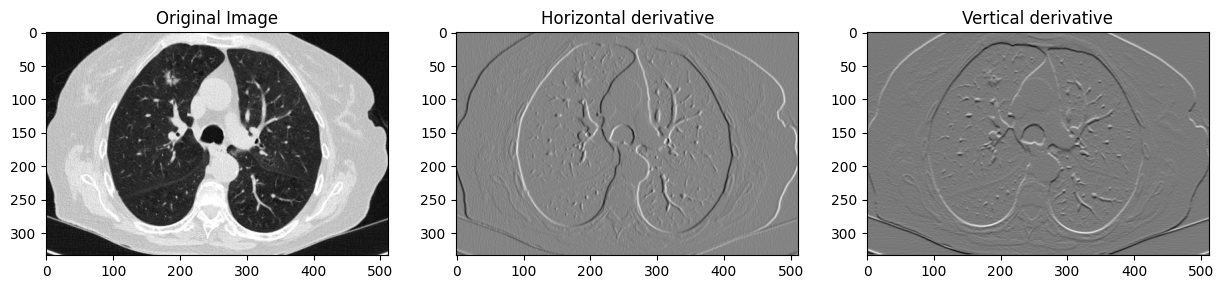

In [21]:
# ASSIGNMENT #2
# Read 'medical_3.jpg', create both kernel derivatives, apply them to the image (separately) and display the original image and the derivatives in a 1x3 plot.
# Write your code here!
image = cv2.imread(images_path + 'medical_3.jpg',0)
K=2
hd = (1/(K+2))*np.array([[1,0,-1],[K,0,-K],[1,0,-1]])
vc = (1/(K+2))*np.array([[-1,-K,-1],[0,0,0],[1,K,1]])
image_hd = cv2.filter2D(image, cv2.CV_16S, hd)
image_vc = cv2.filter2D(image, cv2.CV_16S, vc)
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(image_hd, cmap='gray')
plt.title('Horizontal derivative')
plt.subplot(1,3,3)
plt.imshow(image_vc, cmap='gray')
plt.title('Vertical derivative')

#### <font color='red'>**Expected output** </font>

<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch3_a2_result.png" width="900">
</center>

### **<font color=green><b>ASSIGNMENT #3a: Detecting edges</b></font>**

Complete the following function: `edge_detection()` that:
- Computes the gradient image of an input one using `kernel_h` and `kernel_v` (kernels for horizontal and vertical derivatives respectively).
- Creates the gradient image.
- Normalizes the gradient image to the range $[0,255]$ (check [`cv2.normalize`](https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize)).
- Binarize the normalized image to get the final edges image, using `cv2.threshold`.
- Finally, display in a $1\times3$ plot the original image, the gradient image and the edges image! (Only if `verbose` is True).


In [22]:
# ASSIGNMENT #3a
# Implement a function that that computes the gradient of an image, taking also as input the convolution kernels.
# It must also binarize the resulting image using a threshold
# Show the input image, the gradient image (normalized) and the binarized edge image in a 1x3 plot (if verbose = True)
def edge_detection(image, kernel_h, kernel_v, threshold, verbose=False):
    """ Computed the gradient of the image, binarizes and display it.

        Args:
            image       : [numpy array] grayscale image
            kernel_h    : [numpy array] kernel for horizontal derivative
            kernel_v    : [numpy array] kernel for vertical derivative
            threshold   : [integer] threshold value for binarization [0,255]
            verbose     : [bool] flag for displaying or not the images

        Returns:
            edges       : [numpy array] edges binary image
    """
    # Write your code here!

    image_hd = cv2.filter2D(image, cv2.CV_16S, kernel_h)
    image_vc = cv2.filter2D(image, cv2.CV_16S, kernel_v)
    gradient = np.add(np.abs(image_hd),np.abs(image_vc))
    gradientn = np.copy(gradient)
    gradientn = cv2.normalize(gradient,gradientn, 0, 255, cv2.NORM_MINMAX)

    _,gradientb = cv2.threshold(gradientn,threshold,255,cv2.THRESH_BINARY)

    if verbose == True:
      plt.subplot(1,3,1)
      plt.imshow(image, cmap='gray')
      plt.title('Imagen original')
      plt.subplot(1,3,2)
      plt.imshow(gradient, cmap='gray')
      plt.title('Gradient Image')
      plt.subplot(1,3,3)
      plt.imshow(gradientb, cmap='gray')
      plt.title('Edges detected')

    return gradientb

You can use this code to **test if your results are correct**:

In [23]:
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

kernel_h = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])*1/4
kernel_v = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])*1/4

print(edge_detection(image, kernel_h, kernel_v, 100))

[[  0   0   0]
 [255 255 255]
 [  0 255   0]]


#### <font color='red'>**Expected output**  </font>

    [[  0   0   0]
     [255 255 255]
     [  0 255   0]]

### **<font color=green><b>ASSIGNMENT 3b: Testing our detector</b></font>**
Now **try the implemented method** with different size Sobel kernels ($3\times3$, $5\times5$, ...) and with other operators (Roberts, Prewitt, ...). $\\[5pt]$  

interactive(children=(IntSlider(value=120, description='threshold', max=255, step=10), Output()), _dom_classes…

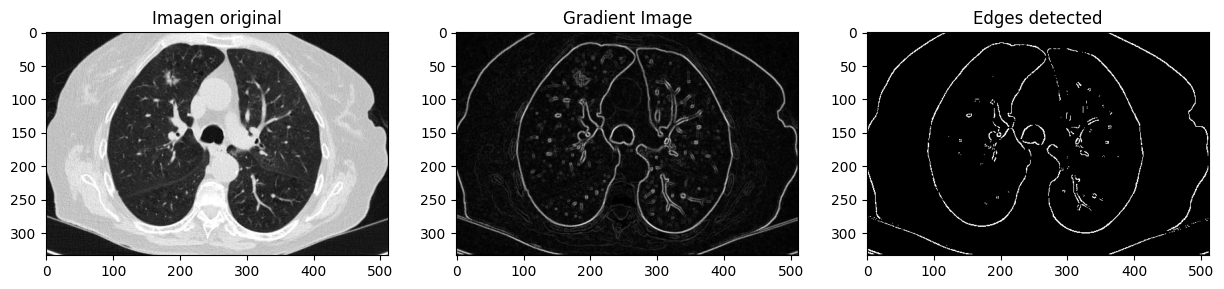

In [24]:
# ASSIGNMENT #3b
# Read the image, set you kernels (Sobel, Roberts, Prewitt, etc.) and interact with the threshold parameter.
# Write your code here!

# Read image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Define kernel (Sobel, Roberts, Prewitt, ...)
# kernel_h = [...]
# kernel_v = [...]
K=2
kernel_h = (1/(K+2))*np.array([[1,0,-1],[K,0,-K],[1,0,-1]],dtype=np.int16)
kernel_v = (1/(K+2))*np.array([[-1,-K,-1],[0,0,0],[1,K,1]],dtype=np.int16)

kernel_h = np.array([[0,0,0],[0,0,1],[0,-1,0]],dtype=np.int16)
kernel_v = np.array([[-1,0,0],[0,1,0],[0,0,0]],dtype=np.int16)

kernel_h = (1/3)*np.array([[1,0,-1],[1,0,-1],[1,0,-1]],dtype=np.int16)
kernel_v = (1/3)*np.array([[-1,-1,-1],[0,0,0],[1,1,1]],dtype=np.int16)
#Interact with your code!
interactive( edge_detection, image=fixed(image), kernel_h=fixed(kernel_h), kernel_v=fixed(kernel_v), threshold=(0,255,10), verbose=fixed(True))

#### <font color='red'>**Expected output**</font>
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch3_a3b_result.png" width="900">
</center>

#### <font color="blue"><b>Discussion #1</b></font>

Now, **answer these questions**:

- What happens if we use a bigger kernel?
  
    <font color=blue><b>Using a larger kernel size will result in decreased localization accuracy and increased computational cost. However, the trade-off is that it will enhance the robustness of the method to noise.</b></font>
   
- There are differences between the Sobel and the other operators?
  
    <font color=blue><b>Different operators undergo variations, assigning distinct weights to adjacent pixels. As a consequence, each operator yields different outcomes as a result of these varying weight assignments</b></font>
    
- What problems do you think that these operators have?

    <font color=blue><b>The potential to generate both false positives and false negatives.</b></font>
    
- Why the kernels usually are divided by a number? (e.g. $3\times3$ Sobel is divided by 4)

    <font color=blue><b>To normalize it, the values are adjusted such that no pixel in the image exceeds a value of 255 when the operator is applied</b></font>

## **3.1.2 DroG operator**

Despite the simplicity of the previous techniques, they have a remarkable drawback: their performance is highly influenced by image noise.

An already studied image processing technique can be used to mitigate such noise: **image smoothing**, and more concretely, **Gaussian filtering**, which already should sound familiar to you. The basic idea is to smooth the image and then apply a gradient operator.

This combination of smoothing and gradient is usually called **Derivative of Gaussian operator (DroG)** (you can find the derivation in the course slides):$\\[5pt]$

$$
DroG(x,y) =
\nabla \left[ g_\sigma (x,y) \right] =
\underbrace{\begin{bmatrix}
\frac{\partial}{\partial x}[g_\sigma(x)g_\sigma(y)] \\
\frac{\partial}{\partial y}[g_\sigma(x)g_\sigma(y)] \end{bmatrix}}_{\text{separability}} =
\underbrace{\begin{bmatrix} \frac{-xg_\sigma(x,y)}{\sigma^2} \\ \frac{-yg_\sigma(x,y)}{\sigma^2}\end{bmatrix}}_{g(x)'=-xg(x)/\sigma^2}
$$

Remember the expression of the Gaussian distribution with 2 variables, with the standard deviation $\sigma$ controlling the degree of smoothness:

$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

> <font color=orange>Take into account that the DroG template or kernels are created just once!</font>

### **<font color=green><b>ASSIGNMENT #4: Applying DroG</b></font>**

We would like to try this robust edge detection technique, so complete the `drog_kernels()` method that constructs the DroG kernels from the Gauss distribution formula above. Finally, it calls `edge_detection()` using those templates.

Its inputs are:
- an image to be processed,
- the kernel aperture size,
- the standard deviation, and
- the gradient image binarization threshold.

In [25]:
# ASSIGNMENT #4
# Implement a function that builds the horizontal and vertical DroG templates and calls to 'edge_detection' using those templates.
# Inputs: an image, the kernel aperture size, the Gaussian standard deviation and the threshold for the gradient image binarization
# It returns the horizontal and vertical kernels
def drog_kernels(image, w_kernel, sigma, threshold, verbose=False):
    """ Construct the DroG operator and call edge_detection_chart.

        Args:
            image       : [numpy array] grayscale image
            w_kernel    : [integer] kernel aperture size (width = 2*w_kernel+1)
            sigma       : [real] standard deviation of the Gaussian distribution
            threshold   : [integer] threshold value for binarization [0,255]
            verbose     : [bool] flag for displaying or not the images

        Returns:
            kernel_h    : [numpy array] DroG horizontal kernel
            kernel_v    : [numpy array] DroG vertical kernel

    """
    # Write your code here!
    kernel_1D = [np.exp(-z*z/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma) for z in range(-w_kernel,w_kernel+1)]
    kernel = np.outer(kernel_1D, kernel_1D)
    kernel_h = np.zeros(kernel.shape)
    kernel_v = np.zeros(kernel.shape)

    for i in range(-w_kernel, w_kernel+1):
        kernel_h[:,i+w_kernel] = -kernel[:,i+w_kernel]/(sigma*sigma)*i
        kernel_v[i+w_kernel,:] = -kernel[w_kernel+i,:]/(sigma*sigma)*i

    edge_detection(image,kernel_h,kernel_v,threshold,verbose)
    return kernel_h, kernel_v

You can use the next code to **test if results are correct**:

In [26]:
# Create an input image
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

# Apply the Gaussian kernel
drog_kernels(image, w_kernel=1, sigma=1.2, threshold=100)

(array([[ 0.03832673, -0.        , -0.03832673],
        [ 0.05423735, -0.        , -0.05423735],
        [ 0.03832673, -0.        , -0.03832673]]),
 array([[ 0.03832673,  0.05423735,  0.03832673],
        [-0.        , -0.        , -0.        ],
        [-0.03832673, -0.05423735, -0.03832673]]))

####<font color='red'>**Expected output:**  </font>

    (array([[ 0.03832673, -0.        , -0.03832673],
            [ 0.05423735, -0.        , -0.05423735],
            [ 0.03832673, -0.        , -0.03832673]]),
     array([[ 0.03832673,  0.05423735,  0.03832673],
            [-0.        , -0.        , -0.        ],
            [-0.03832673, -0.05423735, -0.03832673]]))

#### <font color="blue"><b>Discussion #2</b></font>

Now **try this method** and play with some interactive parameters. Then **answer the following questions**:

- What happens if a bigger kernel is used?
  
    <font color=blue><b>By opting for this approach, we can expect a reduction in localization accuracy, an increase in computational cost, but a notable improvement in noise robustness.</b></font>
    
- What kind of errors appear and disappear when sigma is modified?
  
    <font color=blue><b>When the sigma value is increased, false positives tend to be eliminated, which is beneficial. However, it is important to note that if the sigma value is excessively increased, there is a possibility of introducing false negatives. Conversely, if the sigma value is decreased, the opposite effect can occur, where false negatives are reduced but false positives may become more prominent. Therefore, finding an optimal balance in selecting the sigma value is crucial to achieve the desired trade-off between false positives and false negatives.</b></font>
    
- Now that you have tried different techniques, in your opinion, which is the best one for this type of images?

    <font color=blue><b>In the context of medical images, where clear visualization of edges is essential for study purposes, the Sobel or Prewitt operators offer a computationally efficient solution for calculating these edges. However, the DroG operator yields superior quality results. It is important to note that by adjusting parameters such as sigma or threshold, we can further enhance the performance of the DroG operator. Therefore, considering the overall results, I believe that the DroG operator provides better outcomes for the clear visualization of edges in medical images, with the potential for further improvement by fine-tuning its parameters.</b></font>

interactive(children=(IntSlider(value=3, description='w_kernel', max=5, min=1), FloatSlider(value=2.4, descrip…

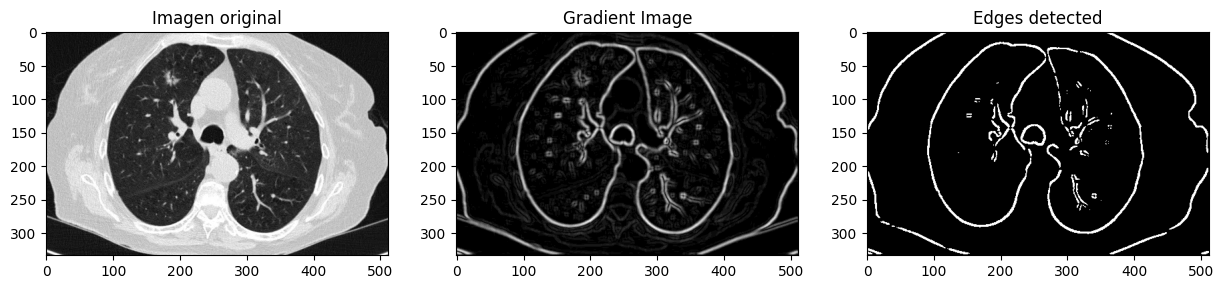

In [27]:
# Read the image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interact with the three input parameters
interactive(drog_kernels, image=fixed(image), w_kernel=(1,5,1), sigma=(0.4,5,0.5), threshold=(0,255,10), verbose=fixed(True))

####<font color='red'>**Expected output**</font>
<center>
<img src="https://raw.githubusercontent.com/famoreno/cv_jn_images/master/ch3/insert/ch3_a4_result.png" width="900">
</center>

### **<font color=green><b>ASSIGNMENT #5: Measuring efficiency</b></font>**

Finally, **you are asked to** compare the execution time of creating a DroG template using your previous code (that is, combining two 1-D Gaussian filters with `np.outer`), with creating a DroG template using a 2-D Gaussian filter (that is, with a 2-D loop).

> <font color=orange>To notice the difference, use a great aperture size (e.g 500).

> Tip: [how to measure execution time in Python](https://stackoverflow.com/questions/14452145/how-to-measure-time-taken-between-lines-of-code-in-python)</font>

In [28]:
# ASSIGNMENT #5
# Write your code here!

import time
print("Measuring the execution time needed for ...")

# Define x and y axis
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)
w=500
sigma=1.2
threshold=100
x = np.arange(-w,w+1)
y = np.vstack(x)

# OPTION 1: Combination of two 1D Gaussian kernels
start = time.process_time() # Start timer

# Create 1D Gaussian filter
# kernel_1D =  [np.exp(-z*z/(2*s*s))/np.sqrt(2*np.pi*s*s) for z in range(-w,w+1)]
kernel_1D = [np.exp(-z*z/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma) for z in range(-w,w+1)]
kernel = np.outer(kernel_1D, kernel_1D)
kernel_h = np.zeros(kernel.shape)
kernel_v = np.zeros(kernel.shape)

# Construct DroG
# gaussian_2D = np.outer(kernel_1D,kernel_1D)
for i in range(-w, w+1):
    kernel_h[:,i+w] = -kernel[:,i+w]/(sigma*sigma)*i
    kernel_v[i+w,:] = -kernel[w+i,:]/(sigma*sigma)*i
#kernel_h = x*(-gaussian_2D)/s**2 # Horizontal derivative
#kernel_v = y*(-gaussian_2D)/s**2 # Vertical derivative
print("DroG building time using 1D Gaussian:", round(time.process_time() - start,5), "seconds") # Stop timer

# OPTION 2: Create 2D Gaussian filter
start = time.process_time() # Start timer

# gaussian_2D = [...]
gaussian_2D = np.array([[np.exp(-(z*z+k*k)/(2*sigma*sigma))/(2*np.pi*sigma*sigma) for z in range(-w,w+1)] for k in range(-w,w+1)])

# Construct DroG
#kernel_h = x*(-gaussian_2D)/s**2 # Horizontal derivative
#kernel_v = y*(-gaussian_2D)/s**2 # Vertical derivativ
for i in range(-w_kernel, w_kernel+1):
    kernel_h[:,i+w_kernel] = -gaussian_2D[:,i+w_kernel]/(sigma*sigma)*i
    kernel_v[i+w_kernel,:] = -gaussian_2D[w_kernel+i,:]/(sigma*sigma)*iimport time


print("DroG building time using 2D Gaussian:", round(time.process_time() - start,5), "seconds") # Stop timer

Measuring the execution time needed for ...
DroG building time using 1D Gaussian: 0.05563 seconds


NameError: ignored

## **Conclusion**

Awesome! Now you have expertise in more applications of the convolution operator. In this notebook you:

- Learned basic operators for edge detection that perform a **discrete approximation of a gradient operator**.
- Learned **how to construct a DroG kernel** in an efficient way.
- Played a bit with them in the context of medical images, discovering some real and important utilities.